In [129]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import catboost as cb

# Pre-processing

## Load data

In [131]:
negative_serology = ["SRR22402286","SRR22402358","SRR22402336","SRR22402315","SRR22402330","SRR22402374","SRR22402370","SRR22402355","SRR22402353","SRR22402352","SRR22402351","SRR22402350","SRR22402349","SRR22402384","SRR22402297","SRR22402275","SRR22402318","SRR22402347","SRR22402383","SRR22402317","SRR22402304","SRR22402371","SRR22402264","SRR22402365","SRR22402369","SRR22402368","SRR22402367","SRR22402366","SRR22402364","SRR22402292","SRR22402299","SRR22402291","SRR22402305","SRR22402277","SRR22402270","SRR22402265","SRR22402259","SRR22402258","SRR22402327","SRR22402319","SRR22402310","SRR22402306","SRR22402303","SRR22402328","SRR22402332","SRR22402331","SRR22402266","SRR22402307","SRR22402333","SRR22402329"]
X = pd.read_csv("../features_family.csv", sep=";")
# filter out samples with negative TG serology
X = X.loc[~X["Sample"].isin(negative_serology)]
y = pd.read_csv("../../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
X.shape

(122, 500)

[Text(0, 0, 'Healthy'), Text(1, 0, 'CD')]

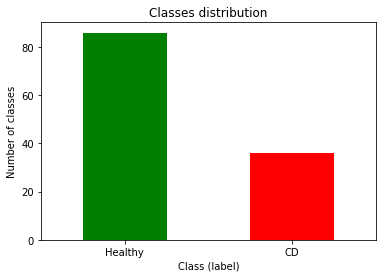

In [134]:
ax = y.value_counts().plot(
  kind='bar',
  color=["green","red"],
  title="Classes distribution",
  ylabel="Number of classes",
  xlabel="Class (label)",
  rot=0
)
ax.set_xticklabels(["Healthy", "CD"])

## Remove features with less than n% unique values

In [136]:
# Calculate the percentage of unique values for each feature
unique_percentages = (X.nunique() / X.shape[0]) * 100

# Identify features with more than 90% same values
features_to_drop = unique_percentages[unique_percentages < 49].index

# Remove the identified features from the DataFrame
filtered_X = X.drop(features_to_drop, axis=1)
filtered_X.shape

(122, 472)

## MRMR to select k features 

In [137]:
selected_features = mrmr_classif(X=filtered_X, y=y, K=30)
X[selected_features]

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9)}

In [122]:
corr_df = X[selected_features].join(y)
corr_m = corr_df.corr()["Label"]
corr_m[abs(corr_m) > 0.2]

Sneathiellaceae                   -0.380303
Candidatus Nanosynbacteraceae      0.258630
Chroococcidiopsidaceae            -0.320639
Pasteurellaceae                    0.247155
Roseiflexaceae                    -0.370030
Kiloniellaceae                    -0.357059
Tropherymataceae                  -0.302482
Sphingosinicellaceae              -0.380127
Rhodospirillaceae                 -0.375080
Thiotrichaceae                    -0.362515
Rikenellaceae                     -0.307836
Idiomarinaceae                    -0.348065
Maricaulaceae                     -0.360634
Phreatobacteraceae                -0.357524
Thalassospiraceae                 -0.347218
Erythrobacteraceae                -0.366951
Nitrospiraceae                    -0.354884
Endozoicomonadaceae               -0.351064
Sulfuricellaceae                  -0.351536
Cyclonatronaceae                  -0.325235
Catenulisporaceae                 -0.333583
Roseobacteraceae                  -0.355998
Colwelliaceae                   

## Split the data

In [123]:
# Create an instance of the SMOTE algorithm
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

Label
1    69
0    69
Name: count, dtype: int64

# Models

## Logistic regression

Classification report:               precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.56      0.62      0.59         8

    accuracy                           0.72        25
   macro avg       0.68      0.69      0.69        25
weighted avg       0.73      0.72      0.72        25

Area under the curve 0.6948529411764706


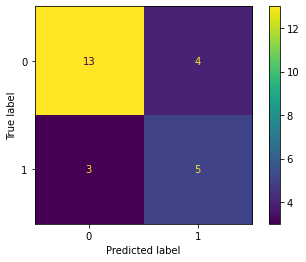

{'logreg__C': 0.6}

In [124]:
pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('min_max_scale', MinMaxScaler()),
    ('logreg', LogisticRegression(random_state=42))
])
# define the hyperparameters to search over
param_grid = {
    'logreg__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_resampled, y_train_resampled)
# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
params = grid_search.best_params_
# print("Accuracy:", accuracy)
print("Classification report:", report)
print("Area under the curve", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_

## Random forest

Accuracy: 0.84
Best score: 0.8552910052910052
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.75      0.75      0.75         8

    accuracy                           0.84        25
   macro avg       0.82      0.82      0.82        25
weighted avg       0.84      0.84      0.84        25

Area under the curve 0.8161764705882352


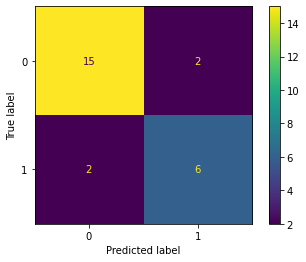

{'rf__criterion': 'entropy',
 'rf__max_depth': 7,
 'rf__max_features': 'log2',
 'rf__n_estimators': 5}

In [125]:
# Define the Pipeline
rf_pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(0.0)), # Step 0: filter out variables with variance < threshold
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('min_max_scaler', MinMaxScaler()),  # Step 2: min-max scaling
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])
rf_param_grid = {
    # 'variance_filter__threshold': [0.1], # grid search value for variance filter threshold
    'rf__n_estimators': [1,2,3,4,5],  # Step 4: grid search for n_estimators
    'rf__max_depth': [1,2,3,4,5,6,7,8,9,10,None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", rf_grid_search.best_score_)
# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
params = rf_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
rf_grid_search.best_params_

In [128]:
f_imp = rf_grid_search.best_estimator_['rf'].feature_importances_
print(f_imp)
rf_grid_search.best_estimator_.feature_names_in_[f_imp > 0.1]

[0.08745752 0.04289418 0.         0.         0.01228095 0.05204675
 0.03280765 0.00894885 0.03962939 0.         0.         0.06258077
 0.         0.05360188 0.02716245 0.16884139 0.04644381 0.16610442
 0.0040023  0.01705267 0.03213122 0.0054267  0.0168983  0.01523757
 0.02327907 0.03584044 0.03685803 0.         0.         0.0124737 ]


array(['Phreatobacteraceae', 'Thalassospiraceae'], dtype=object)